# Text mining
## Homework 01 Feature Selection

In this homework covers three aspects:
1. Text pre-processing (tokenization, lemmatization, stemming, stop words removal, etc.)
2. Feature selection (in our case only token selection).

You will find the steps you need to perform in the **Task** section in each cell, and fill the code snippets marked with `...`. 

In [13]:
%reset -f

In [14]:
# Standard python modules
import string
import math
from collections import Counter
from itertools import chain
from typing import Callable
import itertools

import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from nltk import everygrams
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tqdm.auto import tqdm

# Required for running the nltk modules that we are going to use.
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/work/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/work/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/work/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Globals

In [15]:
datas = []
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space'
]
tfidfs = {}

# TF.IDF class implementation

In this paragraph we are going to create a new class that handles the data processing, cleaning and transformation. Our main goal is to create fit() and transform() methods similar to  [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)
Tasks:

1. Find suitable Lemmatizer and Stemmer from the [NLTK](https://www.nltk.org/) library (recommended WordNet Lemmatizer and Snowball Stammer)
2. Implement missing transformations in preprocess. For stop words you can use again a pre-defined list from NLTK
3. Create N-grams from the single tokens generated by the tokenizer (You will need all n-grams from min_n to max_n)
4. Calculate the idf values using the formulas from below and store then into the self.idf_vec property

**Term Frequency (tf)**: gives us the frequency of the word in each document in the corpus. It is the ratio of number of times the word appears in a document compared to the total number of words in that document. It increases as the number of occurrences of that word within the document increases. Each document has its own tf.

$tf_{i,j} = \frac{n_{i,j}}{\sum_k{n_{i, j}}}$

**Inverse Data Frequency (idf)**: used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score. It is given by the equation below.

$idf(w) = log(\frac{N}{df_t})$

Combining these two we come up with the TF-IDF score (w) for a word in a document in the corpus. It is the product of tf and idf:

$w_{i,j} = tf_{i,j} \times  log(\frac{N}{df_i}) $

Where:

*  $tf_{i,j}$  - number of occurences of term $i$ in document $j$
*  $df_{i}$  - number of document containing term $i$
* $N$ - total number of documents in the corpus

Expected output after tokenization, stop words are not removed:

`He was running and eating at same time . He has bad habit of swimming after playing long hours in the Sun`. 
```
Pre-processed
Tokens              Lemma               Stem                
He                  He                  he                  
was                 be                  was                 
running             run                 run                 
and                 and                 and                 
eating              eat                 eat                 
at                  at                  at                  
same                same                same                
time                time                time                
He                  He                  he                  
has                 have                has                 
bad                 bad                 bad                 
habit               habit               habit               
of                  of                  of                  
swimming            swim                swim                
after               after               after               
playing             play                play                
long                long                long                
hours               hours               hour                
in                  in                  in                  
the                 the                 the                 
Sun                 Sun                 sun    
```

# Task 1

In [16]:
class TfIdf:
    def __init__(self,
                 opt='stem',
                 lower=True,
                 remove_stop_words=True,
                 remove_punkt=True,
                 min_n=1,
                 max_n=2,
                 max_words=1000):

        self.opt = opt
        self.lower = lower
        self.remove_stop_words = remove_stop_words
        self.remove_punkt = remove_punkt
        self.min_n = min_n
        self.max_n = max_n
        self.max_words = max_words
        self.word_freq = None
        self.idf = None

        self.wordnet_lemmatizer = WordNetLemmatizer()
        self.snowball_stem = SnowballStemmer("english")
        self.stop_words = set(stopwords.words("english"))

    def preprocess(self, doc):
        if self.lower:
            # Convert the docence to lower case
            doc = doc.lower()

        words = nltk.word_tokenize(doc)
        if self.opt == "stem":
            # Stem words
            words = [self.snowball_stem.stem(word) for word in words]
        elif self.opt == "lem":
            # Lemmatize words
            words = [self.wordnet_lemmatizer.lemmatize(word) for word in words]

        if self.remove_stop_words:
            # Filter stop words
            words = [word for word in words if not word in self.stop_words]

        if self.remove_punkt:
            # Filter punctuation (you may use string.punctuation)
            words = [word for word in words if not word in string.punctuation]

        # Generate N-grams
        result = []
        for i in range(self.min_n, self.max_n + 1):
            result += nltk.ngrams(words, i)
        words = result
        return words

    def fit(self, data):
        # token: number of documents that contain it
        self.word_freq = Counter()

        # Get the length of data.
        # data is a list of documents (strings) from a category
        N = len(data)

        # new_data holds the vocabulary
        # i.e. the unique tokens
        new_data = []
        # for all documents
        for doc in tqdm(data):
            # preprocess each document to get a list of the tokens
            # a token is either a unigram or a bigram
            tokens = self.preprocess(doc)
            # add the new unique tokens to the vocabulary
            new_data += set(tokens)
            # for all unique tokens
            for w in set(tokens):
                # add 1 since they are contained in the current document
                self.word_freq[w] += 1

        # take the self.max_words most common tokens per category
        # and store them in a list
        self.vocab = [w[0]
                      for w in self.word_freq.most_common()[:self.max_words]]
        # create a mapping between a token and its index in the vocabulary
        self.reverse_vocab = dict(zip(self.vocab, range(len(self.vocab))))

        assert len(self.vocab) == self.max_words, 'Not enough vocab size?'

        # Calculate IDF using the formulas in the description

        idfs = []
        # for each of the most common tokens
        for word in self.vocab:
            tmp_idf = np.log(len(self.vocab)/self.word_freq[word])
            idfs.append(tmp_idf)

        self.idf = np.array(idfs)

    def transform(self, data):
        return self.word_freq

# Data Loading 
We are going to use the 20newsgroup dataset.

First we use the [fetch_20newgroup](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) module from sklearn. 

In [17]:
# We load the data for each category, and create a custom tf-idf object
# This will allow us to calculate the feature metics later.
if len(tfidfs) == 0:
    print('Downloading data ...')
    for category in categories:
        tfidfs[category] = TfIdf()
        data = fetch_20newsgroups(subset='train', categories=[category]).data
        datas.append(data)
        tfidfs[category].fit(data)

    # Create a TfIdf object that includes examples from all the classes
    tfidfs["all"] = TfIdf()
    data_all = fetch_20newsgroups(subset='train', categories=categories).data
    tfidfs["all"].fit(data_all)
else:
    print('Data already present ...')
    for category, category_data in zip(categories, datas):
        tfidfs[category] = TfIdf()
        tfidfs[category].fit(category_data)

    # Create a TfIdf object that includes examples from all the classes
    tfidfs["all"] = TfIdf()
    tfidfs["all"].fit(list(itertools.chain(*datas)))

categories_data_map = dict(zip(categories, datas))
# total number documents
num_docs_all = sum([len(vals) for vals in list(categories_data_map.values())])

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/593 [00:00<?, ?it/s]

  0%|          | 0/2034 [00:00<?, ?it/s]

# Task 2: Feature Selection

Here, the goal is to calculate four different measurements for token importance. Then we will fill a Pandas DataFrame with one row for each token, and one column for each measure. In the notation below: `P` is a probability, `c` is the class, `t` is the token.

The formulas and a worked out examples are given in the lecture.

## IDF
It has been calculated in the `TfIdf` object, we need to retrieve it.

## Chi-Squared ($\chi^2$)

$ \chi^2(c, t) = \sum{\frac{(O - E)^2}{E}}$, where `E` is the expected value, and `O` is the observed (the value in the cells).

This is done for each cell in the 2x2 matrix that has rows the counts of examples in $class$, and $\neg{class}$ (not `class`), and intersected with the columns $token$, and $\neg{token}$.

An additional numeric example can be found [here](https://www.mathsisfun.com/data/chi-square-test.html).

**Note:** this is calculated per-class, you need to do an average.

$\chi^2_{avg}(t) = \sum{P(c_i) * \chi^2(c, t)}$

## Information Gain
The amount of information gained about a random variable or signal from observing another random variable.

$G(t) = -\sum{P(c_i) \log{P(c_i)}} + P(t)\sum{P(c_i|t) \log{P(c_i|t)}} + P(\neg{t})\sum{P(c_i|\neg{t}) \log{P(c_i|\neg{t})}}$

## Mutual Information

Mutual Information quantifies the "amount of information" (in units such as shannons, commonly called bits) obtained about one random variable through observing the other random variable.

$MI(t,c) = \log{\frac{P(t,c)}{P(t)P(c)}} = ... = \log{P(t|c)} - \log{P(t)}$,
using the definition of conditional probability $P(t|c) = \frac{P(t,c)}{P(c)}$.

## Subtasks
1. Calculate all the feature selection metrics for each token
2. Convert them to a Pandas DataFrame
3. Run the code for plotting in the cell below

In [19]:
def get_word_stats(tfidfs, categories, word):
    # May include other relevant metrics, as total examples, etc.
    w_stats = {}

    for category in categories:
        other_categories = [cat for cat in categories if cat != category]
        w_stats[category] = {
            # Number of time the token `t` was seen in the categories `c`
            "t_c": tfidfs[category].word_freq[word],
            # Number of time the token `t` was seen another categories NOT `c`
            "t_Nc": sum([tfidfs[cat].word_freq[word] for cat in categories if cat != category]),
            # Number of tokens in the categories c (that are NOT token `t`)
            "Nt_c": tfidfs[category].word_freq.total() - tfidfs[category].word_freq[word],
            # Number of tokens (that are NOT token `t`) in other categories (NOT `c`)
            "Nt_Nc": sum([tfidfs[cat].word_freq.total() - tfidfs[cat].word_freq[word] for cat in categories if cat != category]),
        }
    return w_stats


def calc_chisq_per_category(w_stats_category: dict) -> float:
    df = pd.DataFrame(
        data=[[w_stats_category['t_c'], w_stats_category['t_Nc']],
              [w_stats_category['Nt_c'], w_stats_category['Nt_Nc']]],
        columns=['in_category', 'other_category'],
        index=['seen_token', 'not_seen_token']
    )

    df['Total'] = df.sum(axis=1)
    df.loc['Total'] = df.sum(axis=0)

    df_expected = df.copy()
    for col in df_expected.columns[:-1]:
        for row in df_expected.index[:-1]:
            df_expected.at[row, col] = df_expected.at[row, 'Total'] * \
                df_expected.at['Total', col] / df_expected.at['Total', 'Total']

    df = df.drop(['Total'], axis=0)
    df = df.drop(['Total'], axis=1)

    for col in df.columns:
        for row in df.index:
            expected_val = df_expected.at[row, col]
            df.at[row, col] = (df.at[row, col] -
                               expected_val)**2 / expected_val

    chi_square = df.values.sum()
    return chi_square


def calc_chisq(w_stats, token):
    # $\chi^2_{avg}(t) = \sum{P(c_i) * \chi^2(c, t)}$
    chi_avg = 0

    # Do the test per category
    for category in w_stats:
        # number of documents from category `c`
        num_docs_c = len(categories_data_map.get(category, None))

        # empirical probability
        prob_category = num_docs_c / num_docs_all

        # normalize by the probability of the category
        chi_avg += prob_category * calc_chisq_per_category(w_stats[category])

    return chi_avg


def calc_infogain(w_stats, w):
    # $G(t) = first_additive + second_additive + third_additive$
    # first_additive  = -\sum{P(c_i) \log{P(c_i)}}
    # second_additive = P(t)\sum{P(c_i|t) \log{P(c_i|t)}}
    # third_additive = P(\neg{t})\sum{P(c_i|\neg{t}) \log{P(c_i|\neg{t})}}

    first_additive = 0
    second_additive = 0
    third_additive = 0

    # P(c_i) = number of documents from category ci
    for category in categories:
        num_docs_c = len(categories_data_map.get(category, None))
        prob_category = num_docs_c / num_docs_all
        first_additive += prob_category * np.log(prob_category)
    first_additive *= (-1)

    # P(t) = number of times token t was seen / total number of tokens
    pt = tfidfs["all"].word_freq[w] / tfidfs["all"].word_freq.total()
    for category in w_stats:
        # P(c_i|t) = from the number of tokens that are t, how many are in category ci
        # P(c_i|t) = P(c_i && t) / P(t)
        p_ci_and_t = tfidfs[category].word_freq[w] / tfidfs["all"].word_freq[w]
        p_ci_t = p_ci_and_t / pt
        if p_ci_t != 0: second_additive += p_ci_t * np.log(p_ci_t)
    second_additive *= pt

    # P(\neg{t}) = 1 - P(t)
    p_neg_t = 1 - pt
    # P(c_i|\neg{t}) = from the number of documents that do not have the token t, how many are from category ci
    for category in w_stats:
        # P(c_i|\neg{t}) = from the number of tokens that are not t, how many are from category ci
        # P(c_i|\neg{t}) = P(c_i && not(t)) / P(not(t))
        p_ci_and_not_t = (tfidfs[category].word_freq.total() - tfidfs[category].word_freq[w]) / (tfidfs['all'].word_freq.total() - tfidfs['all'].word_freq[w])
        p_ci_not_t = p_ci_and_not_t / p_neg_t
        if p_ci_not_t != 0: third_additive += p_ci_not_t * np.log(p_ci_not_t)
    third_additive *= p_neg_t

    g_t = first_additive + second_additive + third_additive
    return g_t


def calc_mutualinformation(w_stats):
    # "t_c": Number of time the token `t` was seen in the categories `c`
    # "t_Nc": Number of time the token `t` was seen another categories NOT `c`
    # "Nt_c": Number of tokens in the categories c (that are NOT token `t`)
    # "Nt_Nc": Number of tokens (that are NOT token `t`) in other categories (NOT `c`)
    
    # $MI(t,c) = \log{P(t|c)} - \log{P(t)}$
    pt = tfidfs["all"].word_freq[w] / tfidfs["all"].word_freq.total()
    
    if pt == 0: return 0
    
    mi_t = 0
    for category in categories:
        p_t_and_c = tfidfs[category].word_freq[w] / tfidfs[category].word_freq.total()
        if p_t_and_c != 0: mi_t += np.log(p_t_and_c) - np.log(pt)
    return mi_t


feature_selection = {}
pbar = tqdm(tfidfs["all"].reverse_vocab.items())
for w, idx in pbar:
    w_stats = get_word_stats(tfidfs, categories, w)
    # Goal is to check whether the token is relevant for the category
    # using various statistical methods
    feature_selection[w] = {
        "Chi Squared": calc_chisq(w_stats, w),
        "Information Gain":  calc_infogain(w_stats, w),
        "Mutual Information": calc_mutualinformation(w_stats),
        "IDF": tfidfs["all"].idf[idx]
    }

feature_selection_df = pd.DataFrame.from_dict(feature_selection)
feature_selection_df

  0%|          | 0/1000 [00:00<?, ?it/s]

,subject,line,organ,write,--,'','s,n't,``,articl,...,letter,matthew,god,share,class,radio,fire,schneider,stephen,1.
,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,'',NaN,NaN,NaN,NaN,subject,NaN,NaN
Chi Squared,14.804892,14.883066,13.992323,12.354641,3.317929,11.031253,1.944010,13.450145,11.081285,9.706410,...,2.467057,7.396934,20.759289,1.486918,2.022893,24.657535,12.615499,49.797287,6.541092,0.603052
Information Gain,4.298690,4.299113,4.338377,4.783657,4.901902,4.911536,4.948015,4.954127,4.982511,5.026660,...,8.025878,8.128305,8.614918,7.985464,8.119617,8.736246,8.291475,9.352028,8.123326,8.019696
Mutual Information,-0.013889,-0.013610,-0.009998,-0.041947,-0.037500,-0.068569,-0.003710,-0.017947,-0.058301,-0.068729,...,-0.203978,-0.620835,-1.322046,-0.025668,-0.795188,-3.908704,-1.559599,1.387155,-0.487136,-0.094094
IDF,-0.710004,-0.709513,-0.669367,-0.231112,-0.112435,-0.108854,-0.057325,-0.054488,-0.035367,0.007025,...,2.975930,2.975930,2.975930,2.975930,2.975930,2.975930,2.975930,2.975930,2.995732,2.995732


In [76]:
# feature_selection_df.to_csv('feature_selection_df.csv')

{'alt.atheism': {'t_c': 480, 't_Nc': 1554, 'Nt_c': 146653, 'Nt_Nc': 440352},
 'talk.religion.misc': {'t_c': 377,
  't_Nc': 1657,
  'Nt_c': 121257,
  'Nt_Nc': 465748},
 'comp.graphics': {'t_c': 584, 't_Nc': 1450, 'Nt_c': 133678, 'Nt_Nc': 453327},
 'sci.space': {'t_c': 593, 't_Nc': 1441, 'Nt_c': 185417, 'Nt_Nc': 401588}}

In [23]:
.index

MultiIndex([(  'subject',       nan),
            (     'line',       nan),
            (    'organ',       nan),
            (    'write',       nan),
            (       '--',       nan),
            (       '''',       nan),
            (       ''s',       nan),
            (      'n't',       nan),
            (       '``',       nan),
            (   'articl',       nan),
            ...
            (   'letter',       nan),
            (  'matthew',       nan),
            (      'god',      ''''),
            (    'share',       nan),
            (    'class',       nan),
            (    'radio',       nan),
            (     'fire',       nan),
            ('schneider', 'subject'),
            (  'stephen',       nan),
            (       '1.',       nan)],
           length=1000)

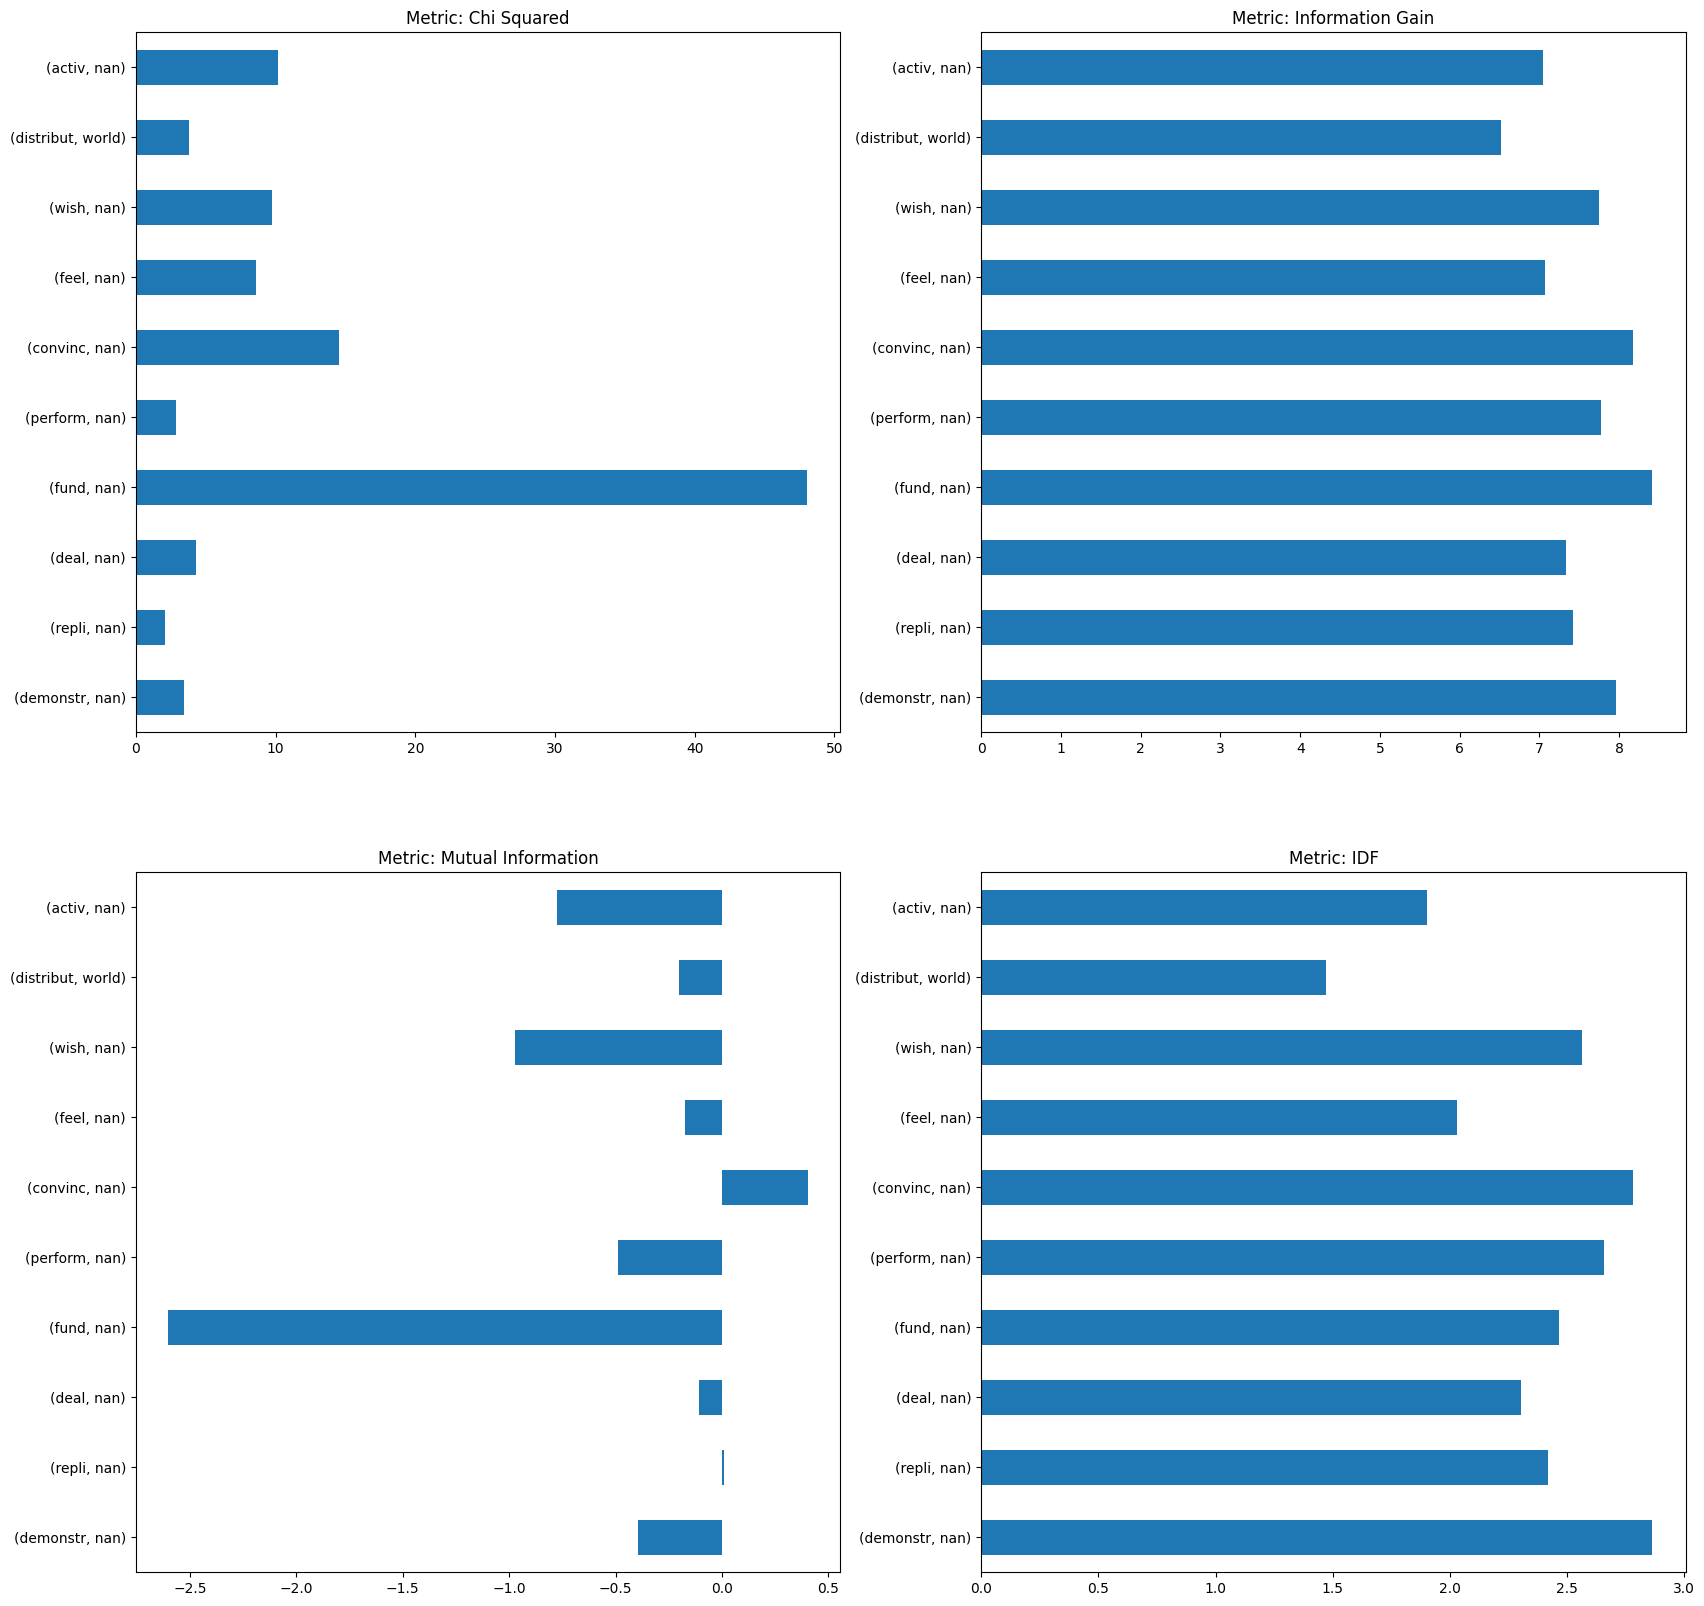

In [24]:
# Sample N words from the vocabulary
sampled_df = feature_selection_df.T.sample(10)

# This works for four categores 2x2, if you add -- change nrows/ncols
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
# This is a 2D array with size nrows x nccols
# We flatten it just for convenience
axes = chain(*axes)


# For each column plot the metrics for the sampled words.
for col, ax in zip(sampled_df.columns, axes):
    sampled_df[col].plot.barh(ax=ax, title=f"Metric: {col}")